In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

In [5]:
# 한글 문제
# matplotlit의 기본 폰트에서 한글 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [6]:
review_data = pd.read_csv('./data/oph_total.csv', encoding = 'utf-8')
review_data2 = pd.read_csv('./data/bct_review.csv', encoding = 'utf-8')
review_data3 = pd.read_csv('./data/total1.csv', encoding = 'utf-8')
review_data4 = pd.read_csv('./data/total2.csv')
df = pd.concat([review_data, review_data2, review_data3, review_data4])
df = df.reset_index()
df
# df.to_csv('../json_csv_files/review_data/final_review_dataframe.csv', index=False, encoding="utf-8-sig")

,index,리뷰어 이름,리뷰어 멤버 id,별점,리뷰 내용,리뷰로부터 도움 받은 사람 수,리뷰 작성일자,Unnamed: 0
0,0,노*희,108878203,3,질염 방광염에 고등학생 딸이 팬티라이너 없인 생활이 곤란했죠. 냉도 많고 냄새도 불...,NaN,2023.12.20,NaN
1,1,한*영,79205694,3,늘 챙겨먹는 유산균이 됐어요ㅎㅎ 으른임에도 캡슐약은 잘 못 삼켜서 물만 한대박 마시...,21.0,2023.06.08,NaN
2,2,김*정,128926123,3,여름만 되면 습해서 가려움 때문에 진짜 고생 많이해요..;; 너무 불편하고 그럴때...,18.0,2021.08.17,NaN
3,3,김*희,154477927,3,이제 7일차입니다 아직 뱃살빠지는 느낌은 없고요 좀더 먹어야 하나봐요 나이가 50...,30.0,2023.08.11,NaN
4,4,최*영,132121964,3,유산균이랑질유산균 둘다 먹고 잇고 변비약도 먹고 잇는데 이 유산균 이 세가지를 다...,6.0,2023.10.11,NaN
...,...,...,...,...,...,...,...,...
133712,50153,김*경,122725714,1,새 제품을 샀는데 이렇게 오는게 맞나요? 아무리 물류센터에서 던지면서 운반 된다고...,8,2022.12.04,50153.0
133713,50154,최*용,119253707,1,전력약함,NaN,2023.09.19,50154.0
133714,50155,샘도아,125262418,1,콘센트가 한번에 팍 고정되는 느낌이 아니라 이리저리 흔들려서 충전이 됐다 안됐다 하네요ㅠ,1,2023.06.03,50155.0
133715,50156,장*민,111333135,1,삼일째 쓰고 있는데 한구는 고장이네요 제일 끝에 있는 데는 불도 안나오고 전기도 안...,NaN,2023.12.16,50156.0


In [7]:
# 별점-1
df['별점'] = df['별점']-1
df.head(3)

,index,리뷰어 이름,리뷰어 멤버 id,별점,리뷰 내용,리뷰로부터 도움 받은 사람 수,리뷰 작성일자,Unnamed: 0
0,0,노*희,108878203,2,질염 방광염에 고등학생 딸이 팬티라이너 없인 생활이 곤란했죠. 냉도 많고 냄새도 불...,NaN,2023.12.20,NaN
1,1,한*영,79205694,2,늘 챙겨먹는 유산균이 됐어요ㅎㅎ 으른임에도 캡슐약은 잘 못 삼켜서 물만 한대박 마시...,21.0,2023.06.08,NaN
2,2,김*정,128926123,2,여름만 되면 습해서 가려움 때문에 진짜 고생 많이해요..;; 너무 불편하고 그럴때...,18.0,2021.08.17,NaN


In [8]:
len(df)

133717

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133717 entries, 0 to 133716
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   133717 non-null  int64 
 1   별점      133717 non-null  int64 
 2   리뷰 내용   133717 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


In [10]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [11]:
df = df.drop('리뷰어 이름', axis=1)
df = df.drop('리뷰로부터 도움 받은 사람 수', axis=1)
df = df.drop('리뷰 작성일자', axis=1)
df = df.drop('리뷰어 멤버 id', axis=1)

In [13]:
df.to_csv("./data/star_review.csv", index=False, encoding = "utf-8-sig")

In [14]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
print('훈련샘플의개수:', len(train_data))
print('테스트 샘플의 개수:', len(test_data))

훈련샘플의개수: 106973
테스트 샘플의 개수: 26744


In [16]:
train_data.head()

,index,별점,리뷰 내용
87874,4315,1,시네빔HU70LA 제품이라 베사홀을 선택했는데 이게 설치할때 약간 헷갈립니다. 후...
70381,23302,1,생각했던것보다 맛은 있었음 둘이 먹는데 양이적었어요ㅠ 손질된거라 편하게 먹었어요 ...
30220,6469,0,문제점을 문의해도 답변이 없네요.. 세개째 폼랜스인데 제가 운이 없던건지 원래 이...
37609,13858,0,까진곳이있어요 힘들게조립한거라 반품시키기 그래서 애가 좋아하니 그냥 씁니당 아이가...
37407,13656,1,신발이 반짝거려서 좋았는데 끄고 켤수가 없어서 건전지 다 되니 4일만에 불빛은 없...


In [17]:
train_data['리뷰 내용'].nunique(), train_data['별점'].nunique()
# 5946 중 4609만 unique하다

(95019, 3)

In [18]:
train_data.drop_duplicates(subset=['리뷰 내용'], inplace=True)
print('총 샘플의 수 : ', len(train_data))

총 샘플의 수 :  95019


<Axes: xlabel='별점'>

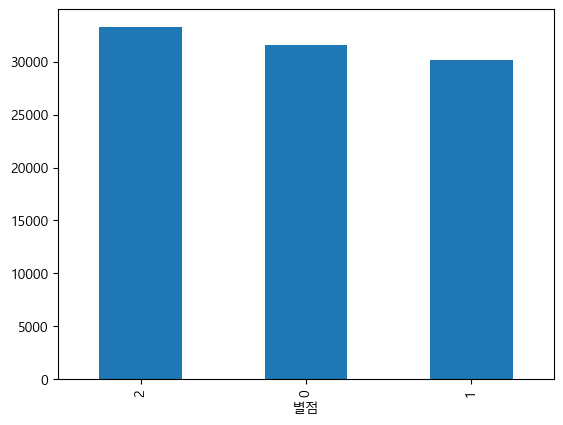

In [19]:
train_data['별점'].value_counts().plot(kind='bar')

In [20]:
train_data.groupby('별점').size().reset_index(name='count')

,별점,count
0,0,31583
1,1,30139
2,2,33297


In [21]:
# 결측치 확인
print(train_data.isnull().values.any())

False


In [22]:
train_data.isnull().sum()

index    0
별점       0
리뷰 내용    0
dtype: int64

In [23]:
print(len(train_data))

95019


In [24]:
import re
def temp(review):
    return re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)

In [25]:
train_data['리뷰 내용'][:5].apply(temp)

87874     시네빔 제품이라 베사홀을 선택했는데 이게 설치할때 약간 헷갈립니다 후기를 보면 분...
70381     생각했던것보다 맛은 있었음 둘이 먹는데 양이적었어요ㅠ 손질된거라 편하게 먹었어요 ...
30220     문제점을 문의해도 답변이 없네요 세개째 폼랜스인데 제가 운이 없던건지 원래 이런건...
37609     까진곳이있어요 힘들게조립한거라 반품시키기 그래서 애가 좋아하니 그냥 씁니당 아이가...
37407     신발이 반짝거려서 좋았는데 끄고 켤수가 없어서 건전지 다 되니 일만에 불빛은 없구...
Name: 리뷰 내용, dtype: object

In [26]:
train_data['리뷰 내용'] = train_data['리뷰 내용'].apply(temp)

train_data[:5]

,index,별점,리뷰 내용
87874,4315,1,시네빔 제품이라 베사홀을 선택했는데 이게 설치할때 약간 헷갈립니다 후기를 보면 분...
70381,23302,1,생각했던것보다 맛은 있었음 둘이 먹는데 양이적었어요ㅠ 손질된거라 편하게 먹었어요 ...
30220,6469,0,문제점을 문의해도 답변이 없네요 세개째 폼랜스인데 제가 운이 없던건지 원래 이런건...
37609,13858,0,까진곳이있어요 힘들게조립한거라 반품시키기 그래서 애가 좋아하니 그냥 씁니당 아이가...
37407,13656,1,신발이 반짝거려서 좋았는데 끄고 켤수가 없어서 건전지 다 되니 일만에 불빛은 없구...


In [27]:
train_data['리뷰 내용'][:10]

87874      시네빔 제품이라 베사홀을 선택했는데 이게 설치할때 약간 헷갈립니다 후기를 보면 분...
70381      생각했던것보다 맛은 있었음 둘이 먹는데 양이적었어요ㅠ 손질된거라 편하게 먹었어요 ...
30220      문제점을 문의해도 답변이 없네요 세개째 폼랜스인데 제가 운이 없던건지 원래 이런건...
37609      까진곳이있어요 힘들게조립한거라 반품시키기 그래서 애가 좋아하니 그냥 씁니당 아이가...
37407      신발이 반짝거려서 좋았는데 끄고 켤수가 없어서 건전지 다 되니 일만에 불빛은 없구...
115288    사이즈 잘 보세요 토마호크 구우려고  샀어요 그런데 이 제품 라인이 특징이 깊이가 ...
72504      이게뭔가요아무리 우유지만 이렇게 배송오면 기분이 좋을까요 다찌그러져서 오고 배송진...
7478      엉망진창 포장배송 주의 맛은 괜춘 가족들 아침대용 건강한 간식으로 구입했어요  그런...
98776     생각보다 커서 좋아요 정리 안된 화초들 예쁘게 정리 생각보다 튼튼하고 예뻐요 조립하...
84036     결점으로 인해 총번교환에도 번째 모니터까지도결점발생 진짜 최악이네요 혹시몰라 무결점...
Name: 리뷰 내용, dtype: object

In [28]:
train_data.isnull().sum()

index    0
별점       0
리뷰 내용    0
dtype: int64

In [29]:
# 테스트데이터 전처리
test_data.drop_duplicates(subset = ['리뷰 내용'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data = test_data.dropna(how='any') # Null 값 제거
test_data['리뷰 내용'] = test_data['리뷰 내용'].apply(temp)
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 25885


In [30]:
stop_total = open("./stopwords/merged_text.txt", 'r', encoding='utf-8')
stopwords = stop_total.read().split()

In [32]:
len(stopwords)

21447

In [33]:
okt = Okt()

In [34]:
X_train = []
for sentence in tqdm(train_data['리뷰 내용']):
    tok_sen = okt.morphs(sentence, stem=True) # 형태소 추출
    stop_rm_tok = []
    for word in tok_sen:
        if (not word in stopwords) and (len(word) != 1):
            stop_rm_tok.append(word)
    X_train.append(stop_rm_tok)

100%|████████████████████████████████████| 95019/95019 [36:26<00:00, 43.45it/s]


In [35]:
test_data['리뷰 내용']

120697     새로이사온집이 우풍이 너무심해서 진짜 엄청검색하다가삼 우풍방지 텐트 종류 엄청다양...
3557      아이가 잘먹어요 꾸준히 아이먹이고 있는제품근데 왜이리 가격이 올랐는지ㅜㅜ가격대비 만...
92922      제니퍼룸 미니 오븐 토스터  신혼집에 토스터기가 필요했는데요 쑝하고 튀어나오는 토...
119559     대체 돌가루물은 언제쯤 안나오는거임 이쯤 되면 내가 절구를 갈고있다는 생각이 듦 ...
94828                   따뜻합니다 안미끌리네요 얼룩이지는건 어쩔수없죠 사이즈는 딱맞아요
                                ...                        
11216     헬륨가스가 풍선 개 넣었더니 없어요 ㅠ 사용하던거 주신듯만원에이건 아닌듯요ㅠ 아들 ...
16276      동결건조 식품이 비싼건 이해하지만  가격대비 양이 아쉽네요  포장은 깔끔하고 아이...
15777     우리애기들 최애간식 살된우리아들도 너무잘먹고 살에 얼마전떠난 우리딸도 정말좋아하는간...
50329      생각보다 작은 크기이지만 비교 가능하게 물티슈랑 같이 놓아두고 사진을 찍었어요 아...
41681      가격대비 구성 괜찮아요 아이가 어린이집에서 블럭으로 맞추는걸 좋아한대서 검색해보고...
Name: 리뷰 내용, Length: 25885, dtype: object

In [36]:
X_test = []
for sentence in tqdm(test_data['리뷰 내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = []
    for word in tokenized_sentence:
        if (not word in stopwords) and (len(word) != 1):
            stopwords_removed_sentence.append(word)
    X_test.append(stopwords_removed_sentence)

100%|████████████████████████████████████| 25885/25885 [10:50<00:00, 39.82it/s]


In [37]:
X_test[:5]

[['진짜',
  '엄청',
  '엄청',
  '다양하다',
  '저렴하다',
  '진짜',
  '비싸다',
  '고민',
  '담다',
  '근데',
  '하루',
  '사이',
  '할인',
  '고민',
  '한번',
  '말다',
  '하루',
  '고민',
  '싸다',
  '세탁',
  '가능하다',
  '보다',
  '닦다',
  '닦다',
  '그닥',
  '많이',
  '크기',
  '사이',
  '늘다',
  '깔다',
  '들어가다',
  '넉넉하다',
  '구르다',
  '아늑하다',
  '느낌',
  '근데',
  '진짜',
  '신기하다',
  '너무',
  '따뜻하다',
  '그렇다고',
  '답답하다',
  '꿀잠'],
 ['먹다',
  '꾸준하다',
  '근데',
  '이리',
  '대비',
  '만족스럽다',
  '꾸준하다',
  '먹이다',
  '오다',
  '판매',
  '대량',
  '팔다',
  '많다',
  '암튼',
  '소비자',
  '로서',
  '좀더',
  '지켜보다'],
 ['제니퍼',
  '토스터',
  '토스터',
  '필요하다',
  '기도',
  '편하다',
  '예쁘다',
  '기도',
  '크다',
  '피자',
  '다양하다',
  '최고',
  '온도',
  '적히다',
  '써다',
  '보고',
  'ㅠㅠ',
  '최초',
  '한번',
  '가열',
  '효과',
  '가보다',
  '편리하다',
  '들다',
  '검정',
  '건지다',
  '빵가루',
  '일도',
  '수월하다',
  '온도',
  '안되다',
  '꺼지다',
  '불량',
  '인가',
  '싶다',
  '내부',
  '온도',
  '꺼지다',
  '정상',
  '한번',
  '이라고',
  '설명',
  '좋다',
  '써다',
  '느끼다',
  '식빵',
  '보다',
  '겉바',
  '편리하다',
  '온도',
  '헤치다',
  '편하다',
  '쿠팡',
  '받다',
  '솔직하다',
  '작성',
 

In [38]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))
print('전처리 후 학습용 샘플의 개수 :',len(X_train))

전처리 후 테스트용 샘플의 개수 : 25885
전처리 후 학습용 샘플의 개수 : 95019


In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [40]:
len(tokenizer.word_index)

33945

In [41]:
# 단어의 등장 횟수가 3개보다 작은 단어들을 제거
filtered_word_counts = {word: count for word, count in tokenizer.word_counts.items() if count >= 3}

# Tokenizer 업데이트: 등장 횟수가 3개보다 작은 단어들이 제거된 상태로 업데이트
tokenizer.word_index = {word: idx for idx, (word, _) in enumerate(sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True), start=1)}
tokenizer.word_counts = filtered_word_counts

In [42]:
tokenizer.word_counts.items()

dict_items([('선택', 4754), ('설치', 4106), ('헷갈리다', 214), ('보다', 65126), ('분명', 320), ('가능하다', 5853), ('처음', 10445), ('안되다', 8068), ('라고', 3447), ('느껴지다', 3218), ('흔들리다', 749), ('아주', 9395), ('좋다', 92720), ('가장', 3034), ('가성', 6721), ('먹다', 49201), ('적다', 4571), ('손질', 938), ('편하다', 12352), ('비싸다', 5764), ('물속', 70), ('피다', 486), ('문제점', 86), ('문의', 533), ('답변', 176), ('인데', 11843), ('건지다', 3351), ('원래', 3496), ('개인', 2860), ('힘들다', 4268), ('반품', 3506), ('좋아하다', 14295), ('신발', 710), ('반짝거리다', 54), ('켜다', 1320), ('일만', 212), ('불빛', 504), ('소중하다', 322), ('다루다', 211), ('다니다', 3820), ('떨어지다', 5614), ('끊어지다', 326), ('버리다', 6918), ('받다', 18150), ('모든', 1518), ('성품', 764), ('엄청', 6754), ('많이', 18784), ('사이즈', 11735), ('자다', 42794), ('우려', 290), ('라인', 958), ('특징', 764), ('깊이', 442), ('깊다', 767), ('건데', 653), ('뜨다', 2599), ('되어다', 21910), ('기준', 1393), ('가지다', 451), ('후라이팬', 1460), ('똑같다', 1227), ('참고', 3783), ('가요', 982), ('아무리', 1098), ('우유', 4471), ('오다', 14400), ('기분', 3863), ('찌그러지다', 756), 

In [43]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0 # 단어의 빈도수가 threshold보다 작은 단어의 수
total_freq = 0 # 훈련데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장빈도수가 threshold보다 작은 단어들의 빈도수 합

In [44]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어 각각의 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [45]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 5049
등장 빈도가 2번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0


In [46]:
# 사용할 단어 수 결정
vocab_size = total_cnt - rare_cnt + 1
vocab_size # 단어의 출연 빈도수가 높은 (3번이상 나오는) 단어의 수
# 이만큼만 단어사전 생성

5050

In [47]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)

In [48]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [49]:
# label 데이터 생성
y_train = np.array(train_data['별점'])
y_test = np.array(test_data['별점'])

In [50]:
print(len(X_train))
print(len(y_train))

95019
95019


In [51]:
print(X_train[:3])

[[86, 104, 1367, 2, 1092, 64, 30, 41, 135, 146, 2, 569, 33, 1, 161, 48, 1], [3, 90, 461, 21, 3, 66, 2141, 803], [2004, 746, 1520, 23, 140, 131, 172]]


In [52]:
drop_train = []
for index, sentence in enumerate(X_train):
    if len(sentence) < 1:
        drop_train.append(index)

drop_train
len(drop_train)

826

In [53]:
drop_test = []
for index, sentence in enumerate(X_test):
    if len(sentence) < 1:
        drop_test.append(index)

drop_test
len(drop_test)

237

In [54]:
# 리뷰 단어가 하나도 없어 제거될 리뷰 index
print(drop_train)

[69, 177, 190, 228, 273, 335, 472, 506, 525, 528, 661, 737, 782, 792, 848, 1129, 1475, 1494, 1739, 1777, 1816, 1877, 1918, 1971, 2025, 2035, 2129, 2291, 2354, 2366, 2391, 2554, 2796, 3304, 3353, 3393, 3553, 3565, 3571, 3578, 3715, 3817, 3847, 3913, 4089, 4123, 4125, 4132, 4187, 4497, 4529, 4583, 4719, 4761, 4893, 5111, 5136, 5198, 5370, 5434, 5668, 5746, 5952, 5975, 6016, 6332, 6533, 6643, 6730, 6777, 6791, 6883, 7066, 7504, 7601, 7688, 7694, 7868, 8058, 8096, 8142, 8409, 8564, 8724, 8749, 8772, 8803, 9012, 9017, 9166, 9242, 9768, 9936, 10173, 10249, 10409, 10483, 10542, 10560, 10625, 10640, 11440, 11543, 11586, 11692, 11844, 11883, 12020, 12058, 12090, 12137, 12348, 12437, 12545, 12548, 12597, 12601, 12761, 12819, 12824, 13119, 13323, 13392, 13539, 13580, 13674, 13696, 13860, 13924, 14010, 14020, 14104, 14395, 14441, 14866, 15305, 15398, 15610, 15653, 15779, 15872, 15912, 16109, 16359, 16640, 16724, 16849, 16919, 16945, 17143, 17394, 17497, 17590, 17666, 17677, 17710, 17754, 17867, 17

In [55]:
len(drop_train)

826

In [56]:
# 해당 index 제거
X_train = np.delete(np.array(X_train, dtype=object), drop_train, axis=0).tolist()
y_train = np.delete(y_train, drop_train, axis=0)

In [57]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

94193
94193
25885
25885


리뷰의 최대 길이 : 462
리뷰의 평균 길이 : 25.08543097682418


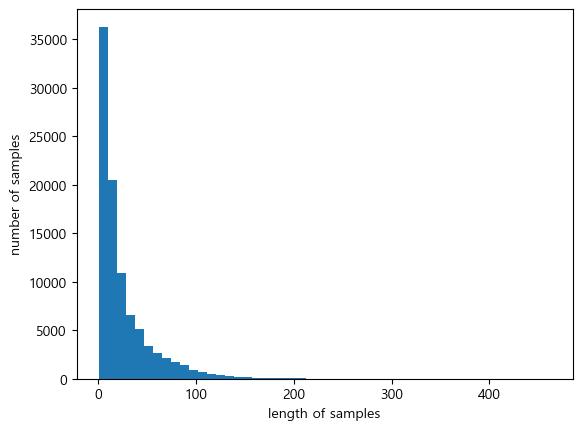

In [58]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [59]:
# 샘플길이가 파라미터 max_len 이하인 샘플 비율 확인 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [60]:
max_len = 300
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 99.98938349983545


In [61]:
# 전체 데이터의 길이는 130으로 맞춘다. 패딩 진행
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [62]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional, SimpleRNN, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('./model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [64]:
embedding_dim = 100 # 1개 단어에 대한 밀집벡터 사이즈
hidden_units = 100 # LSTM의 뉴런 수

In [65]:
partial_x_train, X_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## CNN

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 128))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(MaxPooling1D(2)) # 콘브 층 레이어 갯수 늘려보기
model_cnn.add(Conv1D(128, 7, activation='relu'))
model_cnn.add(MaxPooling1D(2)) # 풀링 갯수 제거
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dropout(0.5)) # 제거
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.Dense(3, activation='softmax'))

In [150]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 128))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(Conv1D(128, 7, activation='relu'))
model_cnn.add(Conv1D(256, 3, activation='relu'))
model_cnn.add(MaxPooling1D(2)) # 풀링 갯수 제거
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(250, activation='relu'))
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(Dense(3, activation='softmax'))

In [151]:
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         646400    
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         114816    
                                                                 
 conv1d_6 (Conv1D)           (None, None, 256)         98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

In [68]:
history_cnn = model_cnn.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, callbacks=[es], validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 16s 16ms/step - loss: 0.8068 - acc: 0.6282 - val_loss: 0.7445 - val_acc: 0.6588
Epoch 2/40
589/589 [==============================] - 9s 15ms/step - loss: 0.7052 - acc: 0.6870 - val_loss: 0.7453 - val_acc: 0.6610
Epoch 3/40
589/589 [==============================] - 8s 14ms/step - loss: 0.6475 - acc: 0.7162 - val_loss: 0.7719 - val_acc: 0.6599
Epoch 4/40
589/589 [==============================] - 9s 15ms/step - loss: 0.5703 - acc: 0.7561 - val_loss: 0.8467 - val_acc: 0.6564
Epoch 5/40
589/589 [==============================] - 9s 15ms/step - loss: 0.4753 - acc: 0.8029 - val_loss: 0.9562 - val_acc: 0.6398
Epoch 5: early stopping


In [69]:
print("\n 테스트 정확도: %.4f" % (model_cnn.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 3s 3ms/step - loss: 0.8337 - acc: 0.6872

 테스트 정확도: 0.6872


In [92]:
history_cnn = model_cnn.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 8s 14ms/step - loss: 0.3840 - acc: 0.8467 - val_loss: 1.1066 - val_acc: 0.6369
Epoch 2/40
589/589 [==============================] - 8s 13ms/step - loss: 0.3014 - acc: 0.8819 - val_loss: 1.2382 - val_acc: 0.6211
Epoch 3/40
589/589 [==============================] - 8s 14ms/step - loss: 0.2489 - acc: 0.9041 - val_loss: 1.4251 - val_acc: 0.6259
Epoch 4/40
589/589 [==============================] - 8s 14ms/step - loss: 0.2079 - acc: 0.9206 - val_loss: 1.5568 - val_acc: 0.6076
Epoch 5/40
589/589 [==============================] - 8s 14ms/step - loss: 0.1862 - acc: 0.9277 - val_loss: 1.6307 - val_acc: 0.5860
Epoch 6/40
589/589 [==============================] - 8s 14ms/step - loss: 0.1649 - acc: 0.9372 - val_loss: 1.7409 - val_acc: 0.6180
Epoch 7/40
589/589 [==============================] - 8s 14ms/step - loss: 0.1483 - acc: 0.9439 - val_loss: 1.8346 - val_acc: 0.6117
Epoch 8/40
589/589 [==============================] - 8s 14ms/step - 

In [93]:
print("\n 테스트 정확도: %.4f" % (model_cnn.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 2s 3ms/step - loss: 2.3657 - acc: 0.6851

 테스트 정확도: 0.6851


In [152]:
history_cnn = model_cnn.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, callbacks=[es], validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 16s 26ms/step - loss: 0.7728 - acc: 0.6475 - val_loss: 0.7995 - val_acc: 0.6472
Epoch 2/40
589/589 [==============================] - 14s 24ms/step - loss: 0.6881 - acc: 0.6935 - val_loss: 0.8160 - val_acc: 0.6376
Epoch 3/40
589/589 [==============================] - 14s 24ms/step - loss: 0.6241 - acc: 0.7282 - val_loss: 0.8018 - val_acc: 0.6526
Epoch 4/40
589/589 [==============================] - 14s 24ms/step - loss: 0.5409 - acc: 0.7694 - val_loss: 0.8674 - val_acc: 0.6492
Epoch 5/40
589/589 [==============================] - 14s 24ms/step - loss: 0.4445 - acc: 0.8154 - val_loss: 1.0503 - val_acc: 0.5956
Epoch 5: early stopping


In [153]:
print("\n 테스트 정확도: %.4f" % (model_cnn.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 3s 4ms/step - loss: 0.9285 - acc: 0.6445

 테스트 정확도: 0.6445


## LSTM

In [70]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 128))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [154]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 128))
model_lstm.add(LSTM(128, return_sequences=True))  # 첫 번째 LSTM 층
model_lstm.add(LSTM(64))  # 두 번째 LSTM 층
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(3, activation='softmax'))

In [155]:
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 128)         646400    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 3)                 195       
                                                                 
Total params: 827,587
Trainable params: 827,587
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_lstm = model_lstm.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, callbacks=[es], validation_data=(X_val, y_val)) 
# train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 18s 27ms/step - loss: 0.7701 - acc: 0.6522 - val_loss: 0.7483 - val_acc: 0.6593
Epoch 2/40
589/589 [==============================] - 15s 26ms/step - loss: 0.7072 - acc: 0.6871 - val_loss: 0.7330 - val_acc: 0.6656
Epoch 3/40
589/589 [==============================] - 17s 28ms/step - loss: 0.6836 - acc: 0.7001 - val_loss: 0.7324 - val_acc: 0.6698
Epoch 4/40
589/589 [==============================] - 17s 28ms/step - loss: 0.6628 - acc: 0.7108 - val_loss: 0.7487 - val_acc: 0.6621
Epoch 5/40
589/589 [==============================] - 17s 28ms/step - loss: 0.6433 - acc: 0.7198 - val_loss: 0.7523 - val_acc: 0.6643
Epoch 6/40
589/589 [==============================] - 17s 28ms/step - loss: 0.6253 - acc: 0.7272 - val_loss: 0.7614 - val_acc: 0.6640
Epoch 7/40
589/589 [==============================] - 17s 29ms/step - loss: 0.6055 - acc: 0.7367 - val_loss: 0.7808 - val_acc: 0.6588
Epoch 7: early stopping


In [73]:
print("\n 테스트 정확도: %.4f" % (model_lstm.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 6s 7ms/step - loss: 0.7247 - acc: 0.6875

 테스트 정확도: 0.6875


In [94]:
history_lstm = model_lstm.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 15s 25ms/step - loss: 0.5859 - acc: 0.7445 - val_loss: 0.8129 - val_acc: 0.6568
Epoch 2/40
589/589 [==============================] - 15s 25ms/step - loss: 0.5667 - acc: 0.7526 - val_loss: 0.8319 - val_acc: 0.6550
Epoch 3/40
589/589 [==============================] - 15s 25ms/step - loss: 0.5476 - acc: 0.7614 - val_loss: 0.8630 - val_acc: 0.6546
Epoch 4/40
589/589 [==============================] - 15s 25ms/step - loss: 0.5262 - acc: 0.7713 - val_loss: 0.9073 - val_acc: 0.6476
Epoch 5/40
589/589 [==============================] - 16s 27ms/step - loss: 0.5065 - acc: 0.7810 - val_loss: 0.9640 - val_acc: 0.6461
Epoch 6/40
589/589 [==============================] - 16s 27ms/step - loss: 0.4883 - acc: 0.7881 - val_loss: 1.0175 - val_acc: 0.6430
Epoch 7/40
589/589 [==============================] - 16s 27ms/step - loss: 0.4810 - acc: 0.7903 - val_loss: 1.0359 - val_acc: 0.6368
Epoch 8/40
589/589 [==============================] - 16s 27ms

In [95]:
print("\n 테스트 정확도: %.4f" % (model_lstm.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 5s 6ms/step - loss: 2.1795 - acc: 0.6725

 테스트 정확도: 0.6725


In [156]:
history_lstm = model_lstm.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, callbacks=[es], validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 29s 47ms/step - loss: 0.7761 - acc: 0.6482 - val_loss: 0.7392 - val_acc: 0.6651
Epoch 2/40
589/589 [==============================] - 28s 48ms/step - loss: 0.7088 - acc: 0.6884 - val_loss: 0.7272 - val_acc: 0.6695
Epoch 3/40
589/589 [==============================] - 28s 48ms/step - loss: 0.6820 - acc: 0.6998 - val_loss: 0.7331 - val_acc: 0.6653
Epoch 4/40
589/589 [==============================] - 28s 48ms/step - loss: 0.6601 - acc: 0.7110 - val_loss: 0.7341 - val_acc: 0.6616
Epoch 5/40
589/589 [==============================] - 29s 50ms/step - loss: 0.6388 - acc: 0.7209 - val_loss: 0.7576 - val_acc: 0.6625
Epoch 6/40
589/589 [==============================] - 28s 48ms/step - loss: 0.6143 - acc: 0.7328 - val_loss: 0.7793 - val_acc: 0.6592
Epoch 6: early stopping


In [157]:
print("\n 테스트 정확도: %.4f" % (model_lstm.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 10s 12ms/step - loss: 0.7265 - acc: 0.6842

 테스트 정확도: 0.6842


## RNN

In [74]:
model_rnn = Sequential()
model_rnn.add(Embedding(vocab_size, 128))
model_rnn.add(SimpleRNN(32, activation='relu'))
model_rnn.add(Dense(8, activation='relu'))
model_rnn.add(Dense(3, activation='softmax'))

In [75]:
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         646400    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 651,843
Trainable params: 651,843
Non-trainable params: 0
_________________________________________________________________


In [76]:
history_rnn = model_rnn.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, callbacks=[es], validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 201s 339ms/step - loss: 0.8114 - acc: 0.6278 - val_loss: 0.7455 - val_acc: 0.6605
Epoch 2/40
589/589 [==============================] - 202s 343ms/step - loss: 0.6953 - acc: 0.6917 - val_loss: 0.7409 - val_acc: 0.6640
Epoch 3/40
589/589 [==============================] - 205s 348ms/step - loss: 0.6548 - acc: 0.7142 - val_loss: 0.7491 - val_acc: 0.6582
Epoch 4/40
589/589 [==============================] - 199s 338ms/step - loss: 0.6175 - acc: 0.7366 - val_loss: 0.7670 - val_acc: 0.6557
Epoch 5/40
589/589 [==============================] - 211s 358ms/step - loss: 0.5793 - acc: 0.7554 - val_loss: 0.7995 - val_acc: 0.6478
Epoch 6/40
589/589 [==============================] - 193s 328ms/step - loss: 0.5456 - acc: 0.7715 - val_loss: 0.8332 - val_acc: 0.6393
Epoch 6: early stopping


In [77]:
print("\n 테스트 정확도: %.4f" % (model_rnn.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 43s 53ms/step - loss: 0.7645 - acc: 0.6738

 테스트 정확도: 0.6738


In [96]:
history_rnn = model_rnn.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 171s 290ms/step - loss: 0.5191 - acc: 0.7859 - val_loss: 1.0042 - val_acc: 0.5593
Epoch 2/40
589/589 [==============================] - 177s 301ms/step - loss: 0.4889 - acc: 0.8008 - val_loss: 0.9715 - val_acc: 0.6369
Epoch 3/40
589/589 [==============================] - 181s 307ms/step - loss: 0.4708 - acc: 0.8091 - val_loss: 0.9317 - val_acc: 0.6314
Epoch 4/40
589/589 [==============================] - 181s 307ms/step - loss: 0.4693 - acc: 0.8096 - val_loss: 1.0096 - val_acc: 0.6281
Epoch 5/40
589/589 [==============================] - 180s 305ms/step - loss: 0.4281 - acc: 0.8289 - val_loss: 1.0463 - val_acc: 0.6241
Epoch 6/40
589/589 [==============================] - 181s 308ms/step - loss: 0.4008 - acc: 0.8402 - val_loss: 1.0874 - val_acc: 0.6232
Epoch 7/40
589/589 [==============================] - 180s 306ms/step - loss: 0.4229 - acc: 0.8312 - val_loss: 1.1023 - val_acc: 0.6127
Epoch 8/40
589/589 [============================

In [97]:
print("\n 테스트 정확도: %.4f" % (model_rnn.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 43s 53ms/step - loss: 1.3985 - acc: 0.6555

 테스트 정확도: 0.6555


## Bi-LSTM

In [98]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(vocab_size, 128))
model_bi_lstm.add(Bidirectional(LSTM(128)))
model_bi_lstm.add(Dropout(0.5))
model_bi_lstm.add(Dense(3, activation='softmax'))

In [100]:
model_bi_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model_bi_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         646400    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                                 
Total params: 910,339
Trainable params: 910,339
Non-trainable params: 0
_________________________________________________________________


In [80]:
print(len(y_val[y_val == 0]))
print(len(y_val[y_val == 1]))
print(len(y_val[y_val == 2]))

6170
6038
6631


In [81]:
print(len(partial_y_train[partial_y_train == 0]))
print(len(partial_y_train[partial_y_train == 1]))
print(len(partial_y_train[partial_y_train == 2]))

24898
23806
26650


In [82]:
history_bi_lstm = model_bi_lstm.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, callbacks=[es], validation_data=(X_val, y_val)) # train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 30s 48ms/step - loss: 0.7711 - acc: 0.6476 - val_loss: 0.7370 - val_acc: 0.6674
Epoch 2/40
589/589 [==============================] - 29s 50ms/step - loss: 0.7102 - acc: 0.6869 - val_loss: 0.7378 - val_acc: 0.6674
Epoch 3/40
589/589 [==============================] - 30s 52ms/step - loss: 0.6875 - acc: 0.6981 - val_loss: 0.7388 - val_acc: 0.6670
Epoch 4/40
589/589 [==============================] - 30s 51ms/step - loss: 0.6693 - acc: 0.7067 - val_loss: 0.7351 - val_acc: 0.6676
Epoch 5/40
589/589 [==============================] - 30s 51ms/step - loss: 0.6492 - acc: 0.7159 - val_loss: 0.7464 - val_acc: 0.6635
Epoch 6/40
589/589 [==============================] - 29s 50ms/step - loss: 0.6283 - acc: 0.7269 - val_loss: 0.7591 - val_acc: 0.6579
Epoch 7/40
589/589 [==============================] - 29s 48ms/step - loss: 0.6098 - acc: 0.7358 - val_loss: 0.7697 - val_acc: 0.6575
Epoch 8/40
589/589 [==============================] - 29s 49ms

In [83]:
print("\n 테스트 정확도: %.4f" % (model_bi_lstm.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 10s 13ms/step - loss: 0.7328 - acc: 0.6810

 테스트 정확도: 0.6810


In [101]:
history_bi_lstm = model_bi_lstm.fit(partial_x_train, partial_y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val)) 
# train에서 0.2정도 빼서 test로

Epoch 1/40
589/589 [==============================] - 32s 52ms/step - loss: 0.7703 - acc: 0.6487 - val_loss: 0.7380 - val_acc: 0.6647
Epoch 2/40
589/589 [==============================] - 32s 54ms/step - loss: 0.7091 - acc: 0.6872 - val_loss: 0.7332 - val_acc: 0.6665
Epoch 3/40
589/589 [==============================] - 33s 55ms/step - loss: 0.6853 - acc: 0.6992 - val_loss: 0.7337 - val_acc: 0.6686
Epoch 4/40
589/589 [==============================] - 31s 53ms/step - loss: 0.6668 - acc: 0.7075 - val_loss: 0.7359 - val_acc: 0.6657
Epoch 5/40
589/589 [==============================] - 31s 53ms/step - loss: 0.6465 - acc: 0.7174 - val_loss: 0.7423 - val_acc: 0.6658
Epoch 6/40
589/589 [==============================] - 31s 53ms/step - loss: 0.6262 - acc: 0.7269 - val_loss: 0.7643 - val_acc: 0.6656
Epoch 7/40
589/589 [==============================] - 31s 53ms/step - loss: 0.6092 - acc: 0.7353 - val_loss: 0.7835 - val_acc: 0.6597
Epoch 8/40
589/589 [==============================] - 31s 53ms

In [102]:
print("\n 테스트 정확도: %.4f" % (model_bi_lstm.evaluate(X_test, y_test)[1]))

809/809 [==============================] - 11s 14ms/step - loss: 2.0422 - acc: 0.6745

 테스트 정확도: 0.6745


## ES 적용 그래프

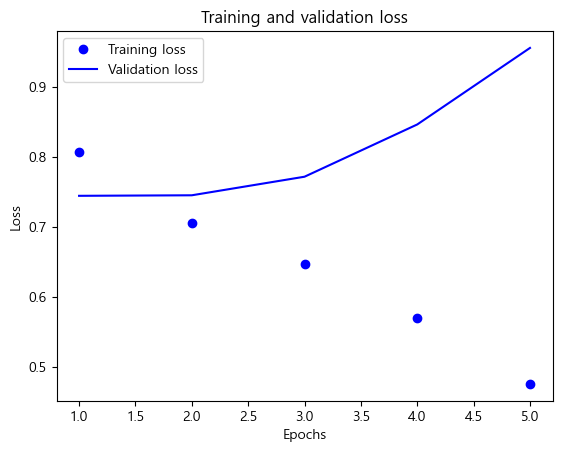

In [84]:
# 손실도 곡선 CNN
import matplotlib.pyplot as plt

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

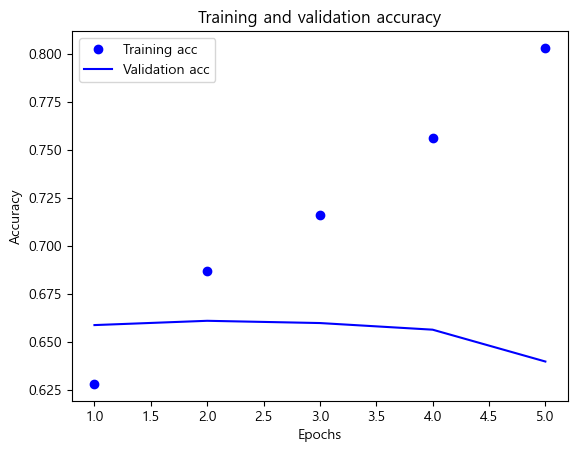

In [85]:
# 정확도 곡선 CNN
plt.clf()

acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

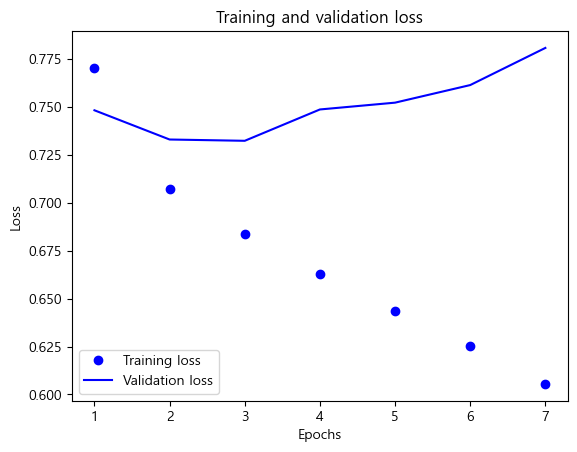

In [86]:
# 손실도 곡선 LSTM
import matplotlib.pyplot as plt

loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

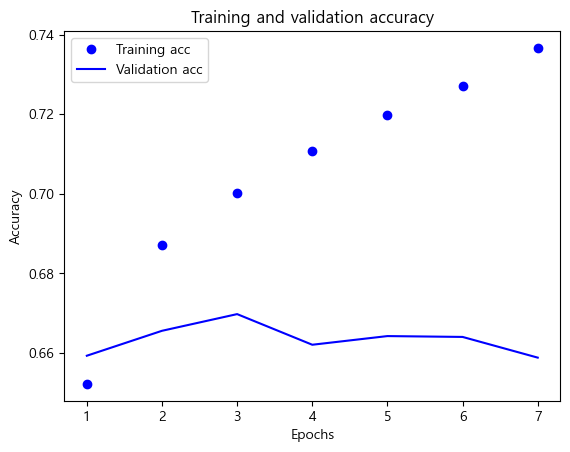

In [87]:
# 정확도 곡선 LSTM
plt.clf()

acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

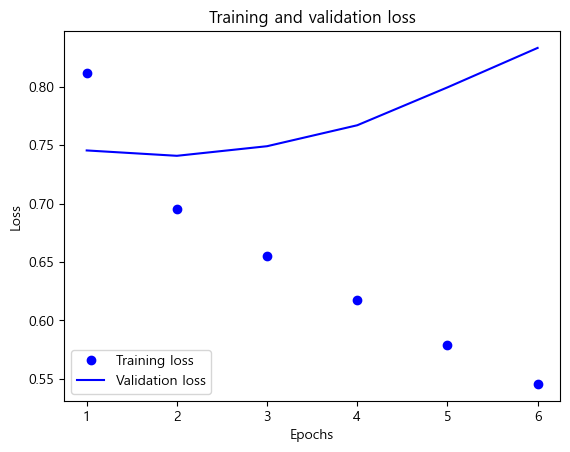

In [88]:
# 손실도 곡선 RNN
import matplotlib.pyplot as plt

loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

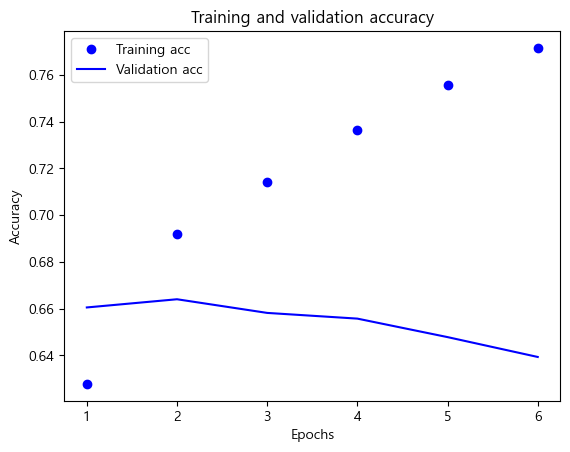

In [89]:
# 정확도 곡선 RNN
plt.clf()

acc = history_rnn.history['acc']
val_acc = history_rnn.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

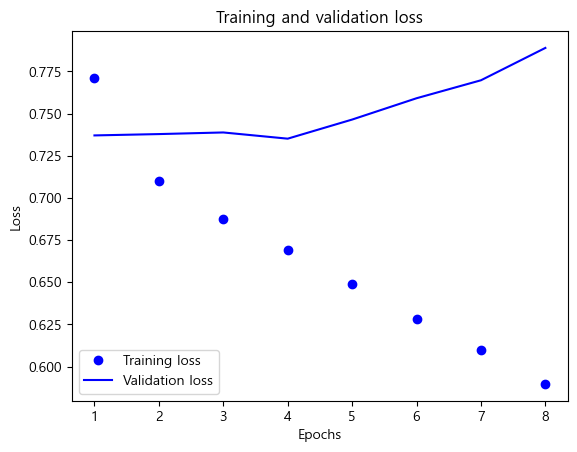

In [90]:
# 손실도 곡선 bi-LSTM
import matplotlib.pyplot as plt

loss = history_bi_lstm.history['loss']
val_loss = history_bi_lstm.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

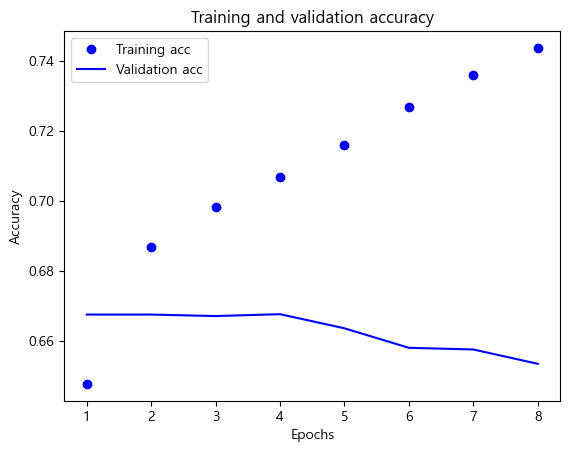

In [91]:
# 정확도 곡선 bi-LSTM
plt.clf()

acc = history_bi_lstm.history['acc']
val_acc = history_bi_lstm.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ES 미적용(Epochs 40) 그래프

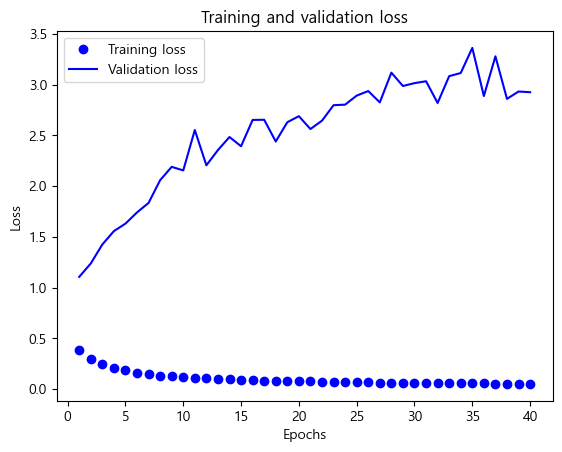

In [103]:
# 손실도 곡선 CNN
import matplotlib.pyplot as plt

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

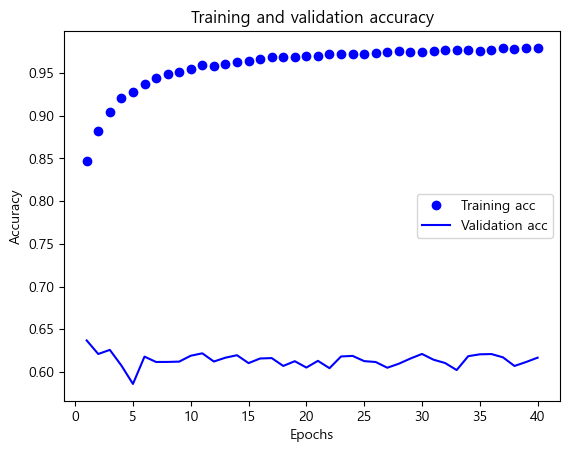

In [104]:
# 정확도 곡선 CNN
plt.clf()

acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

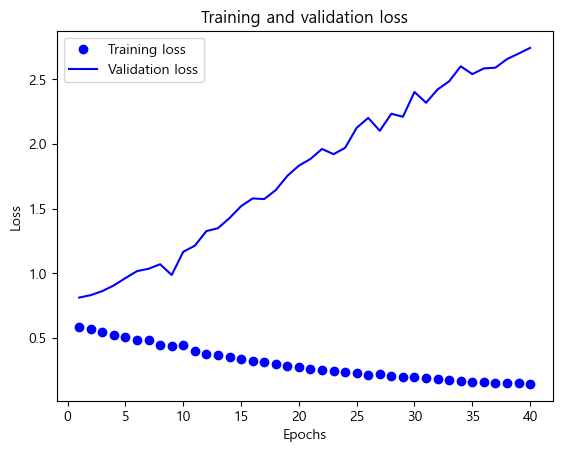

In [105]:
# 손실도 곡선 LSTM
import matplotlib.pyplot as plt

loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

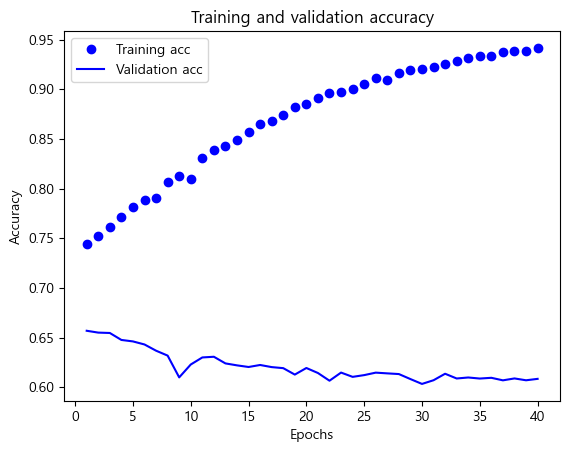

In [106]:
# 정확도 곡선 LSTM
plt.clf()

acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

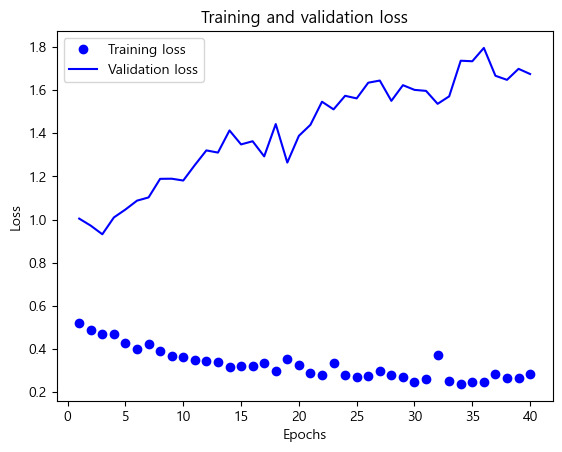

In [107]:
# 손실도 곡선 RNN
import matplotlib.pyplot as plt

loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

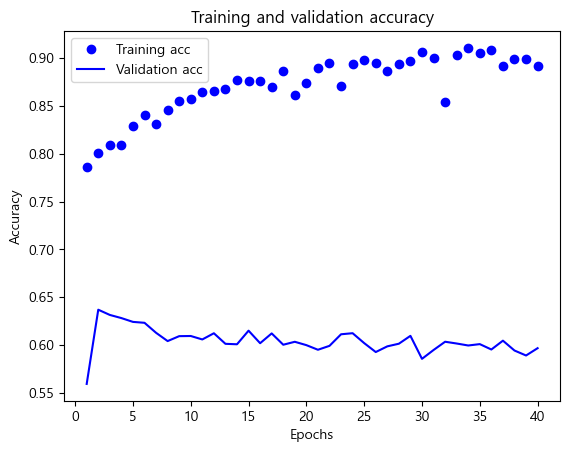

In [108]:
# 정확도 곡선 RNN
plt.clf()

acc = history_rnn.history['acc']
val_acc = history_rnn.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

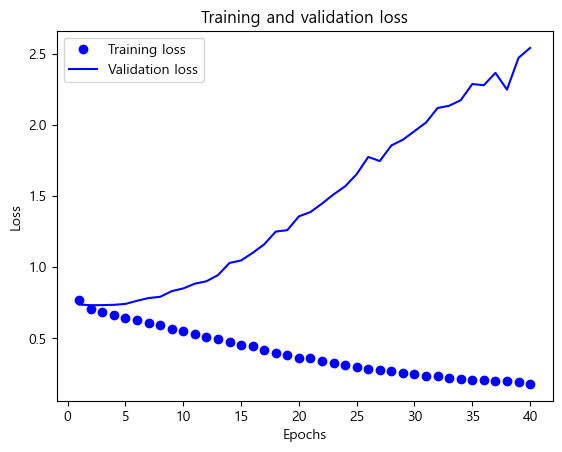

In [109]:
# 손실도 곡선 bi-LSTM
import matplotlib.pyplot as plt

loss = history_bi_lstm.history['loss']
val_loss = history_bi_lstm.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

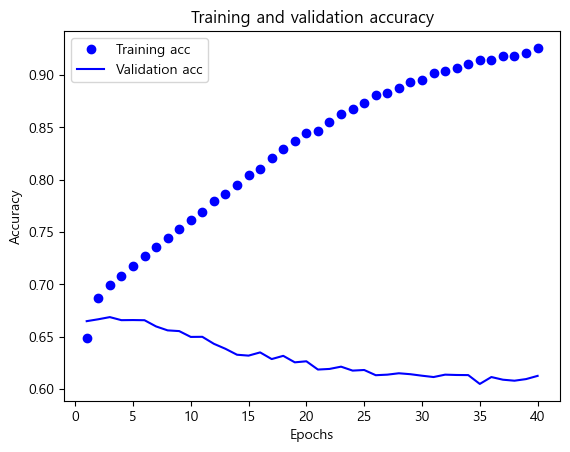

In [110]:
# 정확도 곡선 bi-LSTM
plt.clf()

acc = history_bi_lstm.history['acc']
val_acc = history_bi_lstm.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [131]:
MAX_LENGTH = 150 #문장최대길이

sentence = input('감성분석할 문장을 입력해 주세요.: ')

# 새로 입력된 문장을 전처리
sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', sentence)
# stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'] # 불용어 추가할 것이 있으면 이곳에 추가
sentence = okt.morphs(sentence, stem=True) # 토큰화
sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
print(sentence)

vector  = tokenizer.texts_to_sequences(sentence)
# vector = np.reshape(vector,(1,-1))
pad_new = pad_sequences([vector], maxlen = MAX_LENGTH, padding='post') # 패딩
# model = tf.keras.models.load_model('./model/review.h5')
# print(pad_new)
predictions = model_cnn.predict(pad_new)
print(predictions)

if np.argmax(predictions) == 2:
    print('좋음')
    print(predictions)
elif np.argmax(predictions) == 1:
    print('보통')
    print(predictions)
elif np.argmax(predictions) == 0:
    print('별로')
    print(predictions)

감성분석할 문장을 입력해 주세요.:  쓸 만 해요


['해', '요']


ValueError: in user code:

    File "C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "max_pooling1d" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 150, None, 128)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 150, None), dtype=int32)
      • training=False
      • mask=None


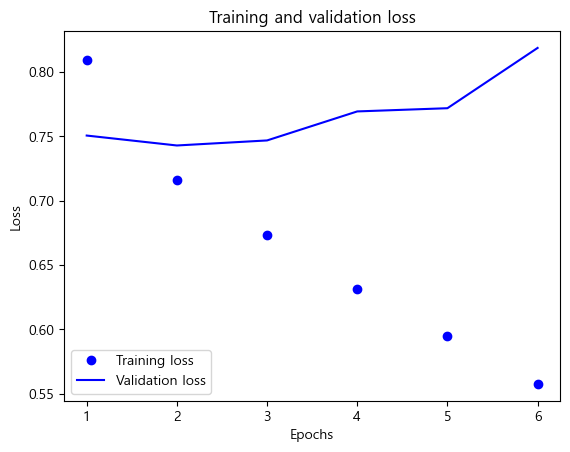

In [146]:
# 손실도 곡선 CNN
import matplotlib.pyplot as plt

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

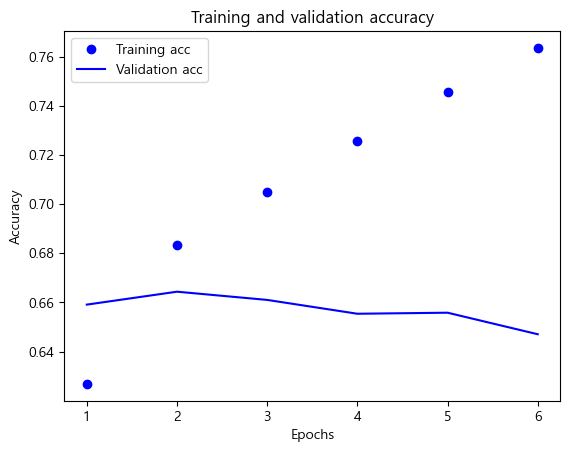

In [147]:
# 정확도 곡선 CNN
plt.clf()

acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()